In [2]:
import transformers
import torch
import datasets
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForSeq2Seq
import matplotlib.pyplot as plt
from vllm import LLM, SamplingParams
import copy

INFO 06-09 23:09:29 [__init__.py:243] Automatically detected platform cuda.


### 基础执行环境信息

In [3]:
print("Transformers version:", transformers.__version__)
print("Torch version:", torch.__version__)
print("Datasets version:", datasets.__version__)
print("VLLM version:", transformers.__version__)

Transformers version: 4.52.3
Torch version: 2.7.0+cu126
Datasets version: 3.6.0
VLLM version: 4.52.3


In [4]:
print("Number of CUDA devices:", torch.cuda.device_count())
print("Current CUDA device:", torch.cuda.current_device())

Number of CUDA devices: 8
Current CUDA device: 0


### 下载数据集
本实验中，我们使用[DeepMath-103K](https://huggingface.co/datasets/zwhe99/DeepMath-103K)数学推理训练集。DeepMath-103K是一个高难度的数学数据集，包含了103K个样本，每个样本带有难度标注以及来自DeepSeek-R1的三条推理路径。此外，DeepMath-103K的一大特点是针对现存的各大数学测试集进行了去重操作，确保训练集中不包含主流数学测试集的样本。

In [ ]:
# 使用datasets的api来加载数据集
data = load_dataset("zwhe99/DeepMath-103K")

In [32]:
data

DatasetDict({
    train: Dataset({
        features: ['question', 'final_answer', 'difficulty', 'topic', 'r1_solution_1', 'r1_solution_2', 'r1_solution_3'],
        num_rows: 103022
    })
})

### Tokenizer与chat_template
Tokenizer的作用是把字符串形式的自然语言文本转化为模型可接受的输入（一个整数id列表）。chat_template是大模型特有的内容，定义了如何把请求组织成对话的形式。

In [ ]:
# 加载Tokenizer
qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Math-1.5B")
print(qwen_tokenizer.chat_template)

{%- if tools %}
    {{- '<|im_start|>system\n' }}
    {%- if messages[0]['role'] == 'system' %}
        {{- messages[0]['content'] }}
    {%- else %}
        {{- 'Please reason step by step, and put your final answer within \\boxed{}.' }}
    {%- endif %}
    {{- "\n\n# Tools\n\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>" }}
    {%- for tool in tools %}
        {{- "\n" }}
        {{- tool | tojson }}
    {%- endfor %}
    {{- "\n</tools>\n\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\n<tool_call>\n{\"name\": <function-name>, \"arguments\": <args-json-object>}\n</tool_call><|im_end|>\n" }}
{%- else %}
    {%- if messages[0]['role'] == 'system' %}
        {{- '<|im_start|>system\n' + messages[0]['content'] + '<|im_end|>\n' }}
    {%- else %}
        {{- '<|im_start|>system\nPlease reason step by step, and

In [ ]:
# 通过apply_chat_template方法可以把一个对话历史转变成带有特殊token的输入格式
# 这里的tokenize=False表示不进行分词，add_generation_prompt=False表示不添加生成提示
# 可以从生成示例中观察到实际用户的输入内容是如何组织的
text = "hello world"
print(qwen_tokenizer.apply_chat_template([{"role": "user", "content": text}, {"role": "assistant", "content": "hi!"}], tokenize=False, add_generation_prompt=False))

<|im_start|>system
Please reason step by step, and put your final answer within \boxed{}.<|im_end|>
<|im_start|>user
hello world<|im_end|>
<|im_start|>assistant
hi!<|im_end|>



### 数据集预处理
我们主要对数据进行以下两步预处理：
1. 筛选数据，只保留答案为纯数字的问题
2. 长度筛选，只保留长度小于4096的问题

In [ ]:
# 数据筛选：只保留答案是纯数字的
data_with_number_answer = data["train"].filter(
    lambda x: x["final_answer"].isdigit()
)
print(len(data_with_number_answer))

In [ ]:
# 数据预处理：每个问题以第一个DeepSeek-R1的输出作为标准答案，将其处理成包含长度（方便后续筛选）、input_ids和labels（用于训练）的格式
def tokenize(example):
    question = example["question"]
    r1_solution = example["r1_solution_1"]
    message = [{"role": "user", "content": question}, {"role": "assistant", "content": f"<think>\n{r1_solution}\n"}]
    result = qwen_tokenizer.apply_chat_template(message, add_generation_prompt=False, tokenize=True, return_dict=True)
    result["length"] = len(result["input_ids"])
    result["labels"] = result["input_ids"].copy()
    return result

train = data_with_number_answer.map(tokenize, batched=False, num_proc=16)

In [ ]:
# 数据示例：R1的回复中包含自我反思、思路切换、验算等高级推理特征
# 此为实际输入模型进行训练的样本
print(qwen_tokenizer.decode(train[0]["input_ids"], skip_special_tokens=False))

<|im_start|>system
Please reason step by step, and put your final answer within \boxed{}.<|im_end|>
<|im_start|>user
Evaluate the limit: \[ \lim_{x \to \infty} \sqrt{x} \left( \sqrt[3]{x+1} - \sqrt[3]{x-1} \right) \]<|im_end|>
<|im_start|>assistant
<think>
Okay, so I have this limit to evaluate: the limit as x approaches infinity of the square root of x times the difference between the cube root of (x plus 1) and the cube root of (x minus 1). Hmm, let me write that down again to make sure I have it right.

\[
\lim_{x \to \infty} \sqrt{x} \left( \sqrt[3]{x+1} - \sqrt[3]{x-1} \right)
\]

Alright, so it's the product of sqrt(x) and the difference of two cube roots. Since x is going to infinity, both x+1 and x-1 are going to be very close to x when x is large. But their cube roots might differ by a small amount, and multiplying by sqrt(x) could amplify that difference. The question is whether this product approaches a finite limit, zero, or infinity.

I remember that when dealing with limi

#### 长度筛选
为了训练方便，我们以Qwen/Qwen2.5-Math-1.5B的最大长度4096为界，只保留长度小于模型最大长度的样本

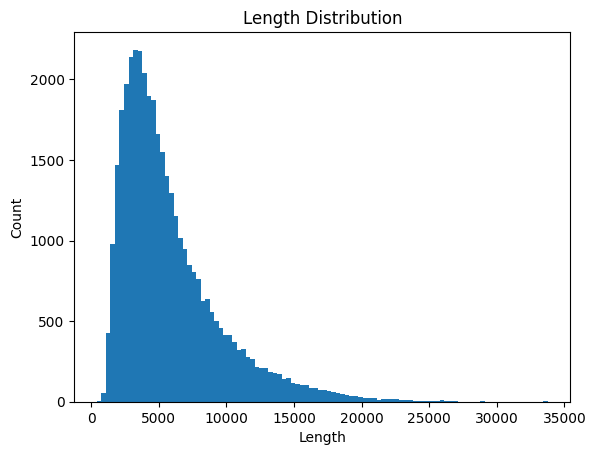

In [ ]:
# 长度分布可视化：R1的回复的长度均值约为5000
lengths = train["length"]
plt.hist(lengths, bins=100)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Length Distribution")
plt.show()

In [ ]:
# 数据筛选：只保留长度小于4096的样本
train = train.filter(lambda x: x["length"] < 4096, num_proc=16)
print(len(train))

15310


### 训练模型
实验方便起见，我们使用Qwen/Qwen2.5-Math-1.5B模型作为实验的基底。Qwen/Qwen2.5-Math-1.5B是一个基座模型，未经过指令微调，因此无法进行正常的指令输出，只能进行普通的ICL生成。我们将加载这个模型，并以BF16的精度进行微调。实验使用单张80GB显存的A100。

In [ ]:
# 加载模型
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-Math-1.5B", torch_dtype=torch.bfloat16, device_map="auto")
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotary_emb): Qw

In [ ]:
# 设置训练的参数
training_args = TrainingArguments(
    # batch size & epochs
    per_device_train_batch_size=4, # 显存不足时，请设置为1
    gradient_accumulation_steps=16,
    num_train_epochs=3,
    # hyperparameters
    learning_rate=1e-6,
    lr_scheduler_type="cosine",
    # monitoring
    output_dir="./checkpoints",
    logging_dir="./checkpoints/logs",
    report_to="tensorboard",
    eval_strategy="no",
    save_strategy="steps",
    save_steps=100,
    save_total_limit=1,
    # efficiency
    bf16=True,
    group_by_length=True,
    torch_compile=True,
    gradient_checkpointing=False, # 显存不足时，请设置为True
    # reproducibility
    seed=42,
    data_seed=42
)

# 设置默认的用于seq2seq任务的DataCollator
collator = DataCollatorForSeq2Seq(
    qwen_tokenizer,
    padding=True,
    pad_to_multiple_of=8,
    return_tensors="pt",
)

In [ ]:
# 使用Trainer进行训练
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    processing_class=qwen_tokenizer,
    data_collator=collator,
)
trainer.train()

In [ ]:
# 训练完毕后，保存最终模型
trainer.save_model("./checkpoints/final_model")

### 测试
训练完模型后，我们需要测试训练得到的模型的性能。我们使用广泛使用的math500测试集。math500是[MATH](https://datasets-benchmarks-proceedings.neurips.cc/paper_files/paper/2021/file/be83ab3ecd0db773eb2dc1b0a17836a1-Paper-round2.pdf)测试集的子集，包含500个高中竞赛级别的数学问题。每个问题标注有对应的难度。

In [ ]:
# 加载数据
math500 = load_dataset("zwhe99/MATH", split="math500")

In [ ]:
# 观察数据格式
math500[0]

{'problem': 'Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\\theta),$ where $r > 0$ and $0 \\le \\theta < 2 \\pi.$',
 'level': 'Level 2',
 'type': 'Precalculus',
 'solution': 'We have that $r = \\sqrt{0^2 + 3^2} = 3.$  Also, if we draw the line connecting the origin and $(0,3),$ this line makes an angle of $\\frac{\\pi}{2}$ with the positive $x$-axis.\n\n[asy]\nunitsize(0.8 cm);\n\ndraw((-0.5,0)--(3.5,0));\ndraw((0,-0.5)--(0,3.5));\ndraw(arc((0,0),3,0,90),red,Arrow(6));\n\ndot((0,3), red);\nlabel("$(0,3)$", (0,3), W);\ndot((3,0), red);\n[/asy]\n\nTherefore, the polar coordinates are $\\boxed{\\left( 3, \\frac{\\pi}{2} \\right)}.$',
 'id': 'test/precalculus/807.json',
 'expected_answer': '(3,\\frac{\\pi}{2})'}

In [ ]:
## 预处理：将问题处理成适合模型输入的对话格式 
data = []
for line in math500:
    line = copy.deepcopy(line)
    line["messages"] = [{"role": "user", "content": line["problem"]}]
    data.append(line)
print(len(data))

500


#### 模型生成
我们使用vllm作为我们的推理后端。`base_model`路径填写实际要测试的模型的路径。

In [ ]:
base_model = "./checkpoints/final_model"
llm = LLM(
    model=base_model,
    tensor_parallel_size=1,
    max_model_len=4096
)
tokenizer = AutoTokenizer.from_pretrained(base_model)

INFO 06-09 10:29:30 [__init__.py:31] Available plugins for group vllm.general_plugins:
INFO 06-09 10:29:30 [__init__.py:33] - lora_filesystem_resolver -> vllm.plugins.lora_resolvers.filesystem_resolver:register_filesystem_resolver
INFO 06-09 10:29:30 [__init__.py:36] All plugins in this group will be loaded. Set `VLLM_PLUGINS` to control which plugins to load.


INFO 06-09 10:29:37 [config.py:793] This model supports multiple tasks: {'score', 'embed', 'classify', 'reward', 'generate'}. Defaulting to 'generate'.
INFO 06-09 10:29:37 [config.py:2118] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 06-09 10:29:38 [utils.py:2531] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reason: CUDA is initialized
INFO 06-09 10:29:41 [__init__.py:243] Automatically detected platform cuda.
INFO 06-09 10:29:43 [core.py:438] Waiting for init message from front-end.
INFO 06-09 10:29:43 [__init__.py:31] Available plugins for group vllm.general_plugins:
INFO 06-09 10:29:43 [__init__.py:33] - lora_filesystem_resolver -> vllm.plugins.lora_resolvers.filesystem_resolver:register_filesystem_resolver
INFO 06-09 10:29:43 [__init__.py:36] All plugins in this group will be loaded. Set `VLLM

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.43it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.43it/s]



INFO 06-09 10:29:45 [default_loader.py:280] Loading weights took 0.35 seconds
INFO 06-09 10:29:45 [gpu_model_runner.py:1549] Model loading took 2.8798 GiB and 0.501736 seconds
INFO 06-09 10:29:50 [backends.py:459] Using cache directory: /data4/home/chenxy/.cache/vllm/torch_compile_cache/18e2887e28/rank_0_0 for vLLM's torch.compile
INFO 06-09 10:29:50 [backends.py:469] Dynamo bytecode transform time: 5.23 s
INFO 06-09 10:29:54 [backends.py:132] Directly load the compiled graph(s) for shape None from the cache, took 3.585 s
INFO 06-09 10:29:55 [monitor.py:33] torch.compile takes 5.23 s in total
INFO 06-09 10:29:56 [kv_cache_utils.py:637] GPU KV cache size: 2,427,344 tokens
INFO 06-09 10:29:56 [kv_cache_utils.py:640] Maximum concurrency for 4,096 tokens per request: 592.61x
INFO 06-09 10:30:12 [gpu_model_runner.py:1933] Graph capturing finished in 17 secs, took 1.47 GiB
INFO 06-09 10:30:12 [core.py:167] init engine (profile, create kv cache, warmup model) took 27.24 seconds


In [ ]:
# 将输入转变成Prompt的格式：VLLM直接推理需要接受经过apply_chat_template方法处理的输入
prompts = [
    tokenizer.apply_chat_template(
        conversation=line["messages"],
        tokenize=False,
        add_generation_prompt=True,
    )
    for line in data
]

# 和训练格式一致：添加<think>标记激发模型思考
prompts = [prompt + "<think>" for prompt in prompts]  # Add newline at the end of each prompt
# 生成参数设置：temperature=0表示贪婪解码，max_tokens=3700是为了适应模型的最大长度
sampling_params = SamplingParams(temperature=0, max_tokens=3700)
# 实际生成
outputs = llm.generate(
    prompts,
    sampling_params,
)

### 数学评测
在这里，我们使用基于规则匹配的方法判断数学题的答案是否正确。我们首先需要从生成的答案中抽取最终的答案值。根据训练时的设定，生成的答案一般会包含在`\\boxed{}`标签中，因此我们可以利用正则表达式来从生成结果中抽取答案，然后将其与正确答案进行比对

In [ ]:
# 安装必要的依赖
!pip install antlr4-python3-runtime==4.11.0

In [5]:
from openmathinst_utils import math_equal, extract_answer

In [ ]:
# 处理生成的输出，将答案提取出来
for line, output in zip(data, outputs):
    line["response"] = output.outputs[0].text
    line["extracted_answer"] = extract_answer(output.outputs[0].text)

In [7]:
# 使用math_equal方法来验证提取的答案是否正确
for line in data:
    line["correct"] = math_equal(line["extracted_answer"], line["expected_answer"])
print("Accuracy:", sum(line["correct"] for line in data) / len(data))

Accuracy: 0.452


### Case Study
在这里，我们随机查看模型生成的内容，观察其生成的特点。通过随机观察样本，我们可以发现：
1. 微调后的模型有了基本的指令遵循能力
2. 模型出现明显的反思倾向，出现大量的“confirm”字样，并且倾向于使用代码来对答案进行检验

In [ ]:
import random

In [ ]:
item = random.choice(data)
print(item["problem"])
print("="*50)
print(item["response"])

Let's start by converting the repeating decimal \(0.\overline{1331}\) into a fraction. We can do this by setting \(x = 0.\overline{1331}\). Then, we can multiply \(x\) by \(10000\) (since the repeating part is 4 digits long) to get \(10000x = 1331.\overline{1331}\). Subtracting the original \(x\) from this equation, we get:

\[10000x - x = 1331.\overline{1331} - 0.\overline{1331}\]
\[9999x = 1331\]
\[x = \frac{1331}{9999}\]

Next, we need to simplify the fraction \(\frac{1331}{9999}\) to its lowest terms. We can do this by finding the greatest common divisor (GCD) of 1331 and 9999. Using the Euclidean algorithm:

1. \(9999 \div 1331 = 7\) with a remainder of \(722\).
2. \(1331 \div 722 = 1\) with a remainder of \(609\).
3. \(722 \div 609 = 1\) with a remainder of \(113\).
4. \(609 \div 113 = 5\) with a remainder of \(44\).
5. \(113 \div 44 = 2\) with a remainder of \(25\).
6. \(44 \div 25 = 1\) with a remainder of \(19\).
7. \(25 \div 19 = 1\) with a remainder of \(6\).
8. \(19 \div 6 